In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
import numpy as np

2024-10-29 19:47:51.817903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 19:47:51.828465: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 19:47:51.831692: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1730231273.067320  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231273.095561  202711 cuda_executor.cc:1015] succ

## learnMSA demo

In this notebook, we will fit a number of HMM models to a dataset of unaligned sequences. 
We will then use the fitted models to align the sequences and compare the results.
Moreover, we will visualize the best (according to an objective criterion) model and alignment.

*This notebook is meant to be a demo for running learnMSA in Python code. Check the readme if you want to run learnMSA from the command line.* 

Change the variables in the following cell to fit your needs.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 10

# Use sequence weights based on a rapid pre-clustering of the sequences (requires mmseqs2 to be installed)
use_weights = True

# Align long insertions with an external aligner left unaligned by the main MSA stage (requires famsa to be installed).
align_insertions = True

## Run learnMSA from Python (Training + Viterbi alignment)

Training of 10 models on file egf.fasta
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100

I0000 00:00:1730231320.705598  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231320.705849  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231320.706031  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231320.706240  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1730231324.437229  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231324.437472  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231324.437650  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231324.437857  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

34/34 - 34s - 1s/step - loss: 97.6311 - loglik: -8.4055e+01 - prior: -1.3576e+01 - aux_loss: 0.0000e+00
Epoch 2/10
34/34 - 4s - 107ms/step - loss: 70.9145 - loglik: -6.8338e+01 - prior: -2.5767e+00 - aux_loss: 0.0000e+00
Epoch 3/10
34/34 - 4s - 105ms/step - loss: 69.1837 - loglik: -6.7231e+01 - prior: -1.9528e+00 - aux_loss: 0.0000e+00
Epoch 4/10
34/34 - 4s - 104ms/step - loss: 68.8849 - loglik: -6.7090e+01 - prior: -1.7946e+00 - aux_loss: 0.0000e+00
Epoch 5/10
34/34 - 4s - 110ms/step - loss: 68.6713 - loglik: -6.6918e+01 - prior: -1.7535e+00 - aux_loss: 0.0000e+00
Epoch 6/10
34/34 - 4s - 112ms/step - loss: 68.6789 - loglik: -6.6961e+01 - prior: -1.7174e+00 - aux_loss: 0.0000e+00


I0000 00:00:1730231380.733423  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231380.733657  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231380.733819  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231380.734010  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: [(12, 2), (13, 3), (18, 2), (20, 2)]
discards model 0: []
expansions model 1: [(12, 2), (14, 2), (15, 1), (18, 1)]
discards model 1: []
expansions model 2: [(12, 4), (13, 2), (16, 1), (18, 2)]
discards model 2: []
expansions model 3: [(12, 9), (13, 1)]
discards model 3: []
expansions model 4: [(12, 7), (15, 1), (17, 2)]
discards model 4: []
expansions model 5: [(12, 2), (13, 2), (14, 1)]
discards model 5: []
expansions model 6: [(10, 1), (11, 2), (12, 3), (13, 1), (16, 1), (18, 2)]
discards model 6: []
expansions model 7: [(12, 4), (13, 2), (16, 1), (18, 2)]
discards model 7: []
expansions model 8: [(12, 2), (13, 3), (14, 1), (17, 1), (19, 2)]
discards model 8: []
expansions model 9: [(12, 4), (13, 2), (16, 1), (18, 2)]
discards model 9: []
Re-initialized the encoder parameters.
Fitting models of lengths [35, 33, 33, 32, 33, 33, 34, 33, 34, 33] on 7774 sequences.
Batch size= 256 Learning rate= 0.1
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347

I0000 00:00:1730231387.755280  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231387.755527  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231387.755713  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231387.755918  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1730231391.081305  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231391.081539  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231391.081714  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231391.081916  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

34/34 - 34s - 993ms/step - loss: 76.6205 - loglik: -6.3794e+01 - prior: -1.2826e+01 - aux_loss: 0.0000e+00
Epoch 2/10
34/34 - 4s - 116ms/step - loss: 65.3976 - loglik: -6.3245e+01 - prior: -2.1531e+00 - aux_loss: 0.0000e+00
Epoch 3/10
34/34 - 4s - 115ms/step - loss: 64.7012 - loglik: -6.3368e+01 - prior: -1.3337e+00 - aux_loss: 0.0000e+00
Epoch 4/10
34/34 - 4s - 122ms/step - loss: 64.3386 - loglik: -6.3188e+01 - prior: -1.1506e+00 - aux_loss: 0.0000e+00
Epoch 5/10
34/34 - 4s - 118ms/step - loss: 64.3664 - loglik: -6.3306e+01 - prior: -1.0604e+00 - aux_loss: 0.0000e+00
Time for alignment: 122.8737
Likelihoods:  ['-59.2383', '-59.0895', '-59.0999', '-59.0713', '-59.0779', '-59.2054', '-59.0690', '-59.0817', '-59.1041', '-59.1798']
Mean likelihood:  -59.12168532779536
Selection criterion: AIC
Best model:  3 (0-based)


I0000 00:00:1730231445.689288  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231445.689527  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231445.689702  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231445.689908  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Aligning 2 insertion slices with famsa.


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


time for generating output: 4.1420
Wrote file test/data/interactive.alignment.fasta
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step
>l=-54.75_t=0.01
............$CD.......P........N............P........CYN.HG..T..C...S........L......R......................AT...-.....G..........YTCSCL....P.R......YT....GEH$.......................
>l=-57.31_t=0.01
............$CD.......S........Q............P........CRN.-G..T..C...S........L......N......................TN...T.....D..........YTCACF....P.G......YT....GRY$.......................
>l=-50.80_t=0.01
............$CD.......S........D............P........CLN.GG..T..C...T........L......R......................SL...D.....S..........YSCACA....P.G......YT....GQH$.......................
>l=-63.88_t=0.01
............$CD.......H........V............T........CLN.GG..T..C...Q........Lk.....T......................LE...-.....D..........YTCACA....N.G......YT....GER$.......................
>l=-64.74_t=0.01
............$CD.......H........V............T........CLN.GG..T

/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1730231456.267192  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231456.267410  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231456.267602  202711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but 

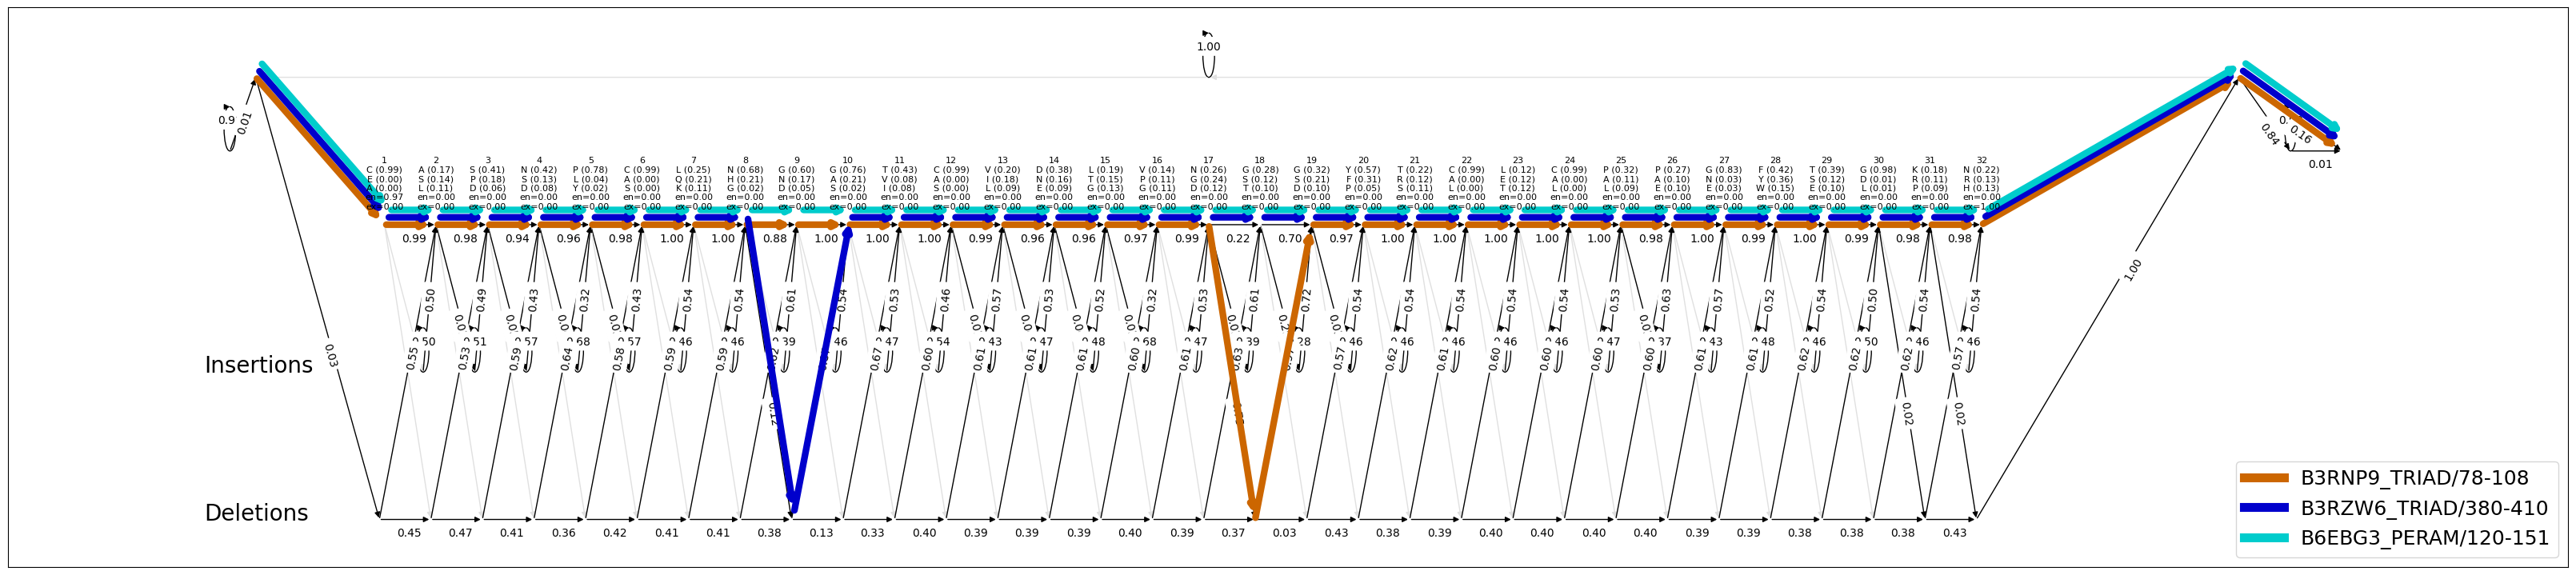

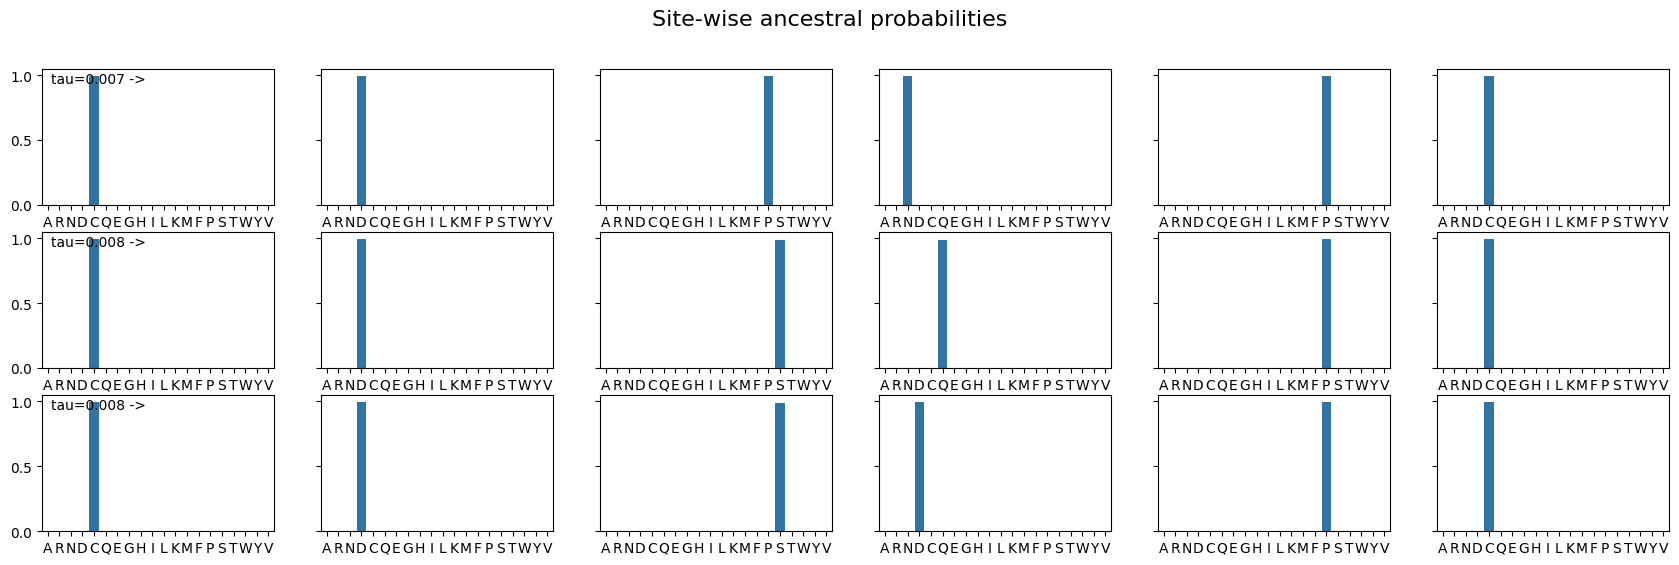

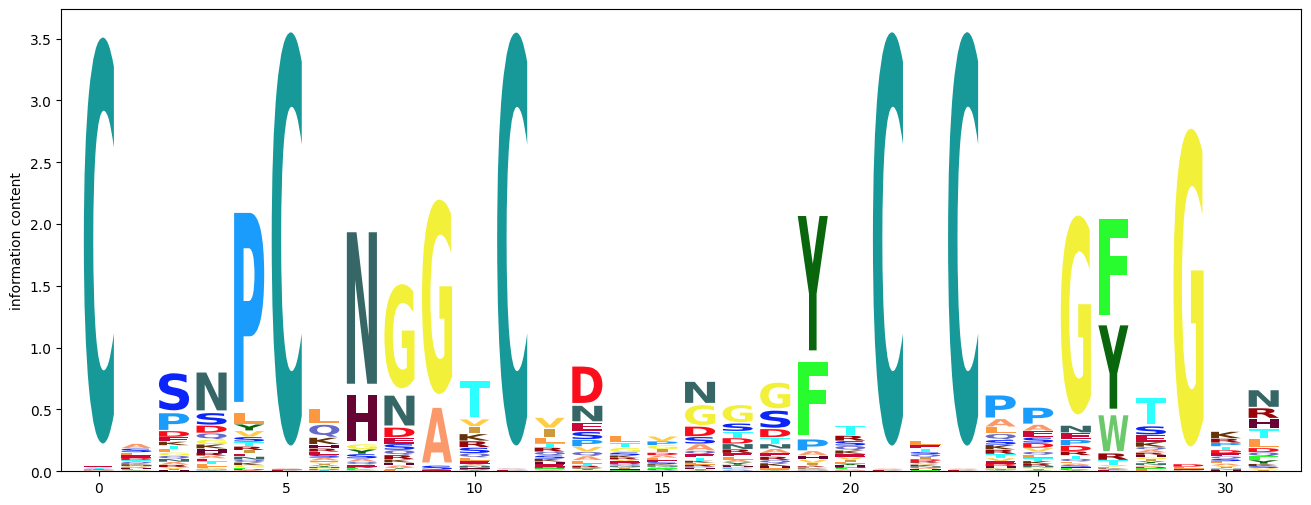

In [3]:
out_filename = "test/data/interactive.alignment.fasta"
config = Configuration.make_default(num_models)
with SequenceDataset(train_filename, fmt="fasta") as data:
    config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) #comment out to disable cropping
    config["max_surgery_runs"] = 2
    alignment_model = Align.run_learnMSA(data,
                                        out_filename,
                                        config, 
                                        sequence_weights=Align.compute_sequence_weights(train_filename, "tmp") if use_weights else None,
                                        verbose=True,
                                        align_insertions=align_insertions)
    Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [6]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [7]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    77.0 [100.0]   [ 5182]
